#  FINM 33150 - Regression Analysis and Quantitative Trading Strategies
## Homework 8 : Robust Regression And Equity Beta
## Suraj Kaul (skaul) - UCID 12214950
## 5/8/2019

## 0. Logistics

### Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import quandl
import matplotlib.dates as mdates
import statsmodels.api as sm
import functools
import seaborn as sns
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
plt.style.use('seaborn')
import time as tm

### Function for getting Data from Quandl

In [2]:
@functools.lru_cache(maxsize=16)
def fetch_quandl(my_securities):
    qdata = quandl.get(list(my_securities), returns="pandas",authtoken='MgKeNNH7rTeBnh4t1667',start_date="2019-01-01",end_date="2019-03-08",column_index='4')
    return qdata

## 1. Data Setup and Cleaning

### Excel file with list of Securities in the ETF's

In [3]:
df=pd.read_excel("ETF Data.xlsx",None)

In [11]:
ticks=[]
for sheet in df.keys():
    data=df[sheet]["Ticker"]
    ticks.extend(data)

In [12]:
sec_list=np.array(sorted((list(set(ticks)))))

### The total securities is 309 names

In [13]:
sec_list

array(['A', 'AAP', 'ABBV', 'ABG', 'ABT', 'ACAD', 'ADI', 'AEE', 'AEO',
       'AEP', 'AES', 'AFL', 'AGIO', 'AGN', 'AIG', 'ALGN', 'ALL', 'ALNY',
       'ALXN', 'AMAT', 'AMD', 'AMGN', 'AMP', 'AMZN', 'AN', 'ANF', 'ANTM',
       'AON', 'APA', 'APC', 'APY', 'AR', 'ARNA', 'ARRY', 'ARWR', 'ASML',
       'ATO', 'ATVI', 'AVGO', 'AWK', 'AXP', 'AZO', 'BAC', 'BAX', 'BBT',
       'BBY', 'BDX', 'BHGE', 'BHVN', 'BIIB', 'BJ', 'BK', 'BKNG', 'BLK',
       'BLUE', 'BMRN', 'BMY', 'BOOT', 'BRK_B', 'BSX', 'BURL', 'C', 'CASY',
       'CB', 'CBS', 'CCOI', 'CDEV', 'CDNS', 'CELG', 'CERN', 'CHK', 'CHTR',
       'CI', 'CJ', 'CLB', 'CLR', 'CMCSA', 'CME', 'CMS', 'CNC', 'CNP',
       'COF', 'COG', 'CONN', 'COP', 'COST', 'CPE', 'CRC', 'CRZO', 'CTL',
       'CVNA', 'CVS', 'CVX', 'CXO', 'D', 'DFS', 'DG', 'DHR', 'DIS',
       'DISCK', 'DISH', 'DK', 'DLTR', 'DO', 'DRQ', 'DTE', 'DUK', 'DVN',
       'EA', 'EBAY', 'ED', 'EIX', 'EOG', 'EQT', 'ES', 'ESPR', 'ESV',
       'ETR', 'EVRG', 'EW', 'EXAS', 'EXC', 'EXEL', 'FANG', 'FB',

In [14]:
index_list=list(df.keys())
index_list.extend(["SPY","QQQ"])

### List of Indexes

In [15]:
index_list

['XLU', 'VOX', 'SMH', 'XBI', 'XLF', 'XOP', 'OIH', 'XRT', 'XLV', 'SPY', 'QQQ']

In [16]:
mat=pd.DataFrame(index=sec_list).rename_axis("Ticker")
mat.head()

""
Ticker
A
AAP
ABBV
ABG
ABT


In [17]:
for sheet in df.keys():
    temp=(df[sheet]["Ticker"].to_frame()).set_index("Ticker")
    temp[sheet]=1
    mat=mat.join(temp,how="outer")
mat=mat.assign(SPY=1.0,QQQ=1.0)

### mat has a mapping for each Ticker to it's ETFs

In [18]:
mat.head()

,XLU,VOX,SMH,XBI,XLF,XOP,OIH,XRT,XLV,SPY,QQQ
Ticker,,,,,,,,,,,
A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0
AAP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0
ABBV,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0
ABG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0
ABT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0


In [19]:
tickers_EOD = []
for x in (sec_list): tickers_EOD.append('EOD/'+x)

In [20]:
index_EOD = []
for x in index_list: index_EOD.append('EOD/'+x)

### Getting Index Data from Quandl/CSV
    CSV is attached with the submission and Quandl is setup to False by default but can change that to import data from Quandl instead of CSV

In [21]:
if False:
    index_data=fetch_quandl(tuple(index_EOD))
    index_data.to_excel("index_data.xlsx")
    
else:
    index_data=pd.read_excel("index_data.xlsx").set_index("Date")

### Creating a Returns dataframe for Index

In [22]:
index_data.columns=index_list
index_ret=index_data.pct_change().dropna()
index_ret.head()

,XLU,VOX,SMH,XBI,XLF,XOP,OIH,XRT,XLV,SPY,QQQ
Date,,,,,,,,,,,
2019-01-03,-0.000192,-0.013459,-0.060055,-0.022646,-0.022481,-0.006962,0.008351,-0.013952,-0.020305,-0.023863,-0.032670
2019-01-04,0.014808,0.041470,0.046588,0.053504,0.033220,0.056458,0.048309,0.030739,0.029831,0.033496,0.042785
2019-01-07,-0.006822,0.009339,0.019309,0.059717,0.001237,0.034230,0.038841,0.031006,0.003839,0.007885,0.011906
2019-01-08,0.012402,0.016962,-0.005785,0.012327,0.000823,0.009119,0.010139,0.008724,0.007765,0.009395,0.009045
2019-01-09,-0.006031,-0.002401,0.025556,0.004225,0.004936,0.022423,0.025094,0.008421,0.004485,0.004673,0.008149


###  Similarly for Security level Data
    CSV is attached with the submission and Quandl is setup to False by default but can change that to import data from Quandl instead of CSV

In [23]:
if False:
    sec_data=fetch_quandl(tuple(tickers_EOD))
    sec_data.to_excel("sec data _v2.xlsx")
else:
    sec_data=pd.read_excel("sec data _v2.xlsx").set_index("Date")

In [24]:
sec_data.columns=sec_list
sec_ret=sec_data.pct_change().dropna()
sec_ret.head()

,A,AAP,ABBV,ABG,ABT,ACAD,ADI,AEE,AEO,AEP,...,WMT,WPX,XEC,XEL,XLNX,XOM,ZAYO,ZBH,ZNGA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.036840,0.031218,-0.032949,-0.004110,-0.047194,-0.028829,-0.060405,0.002518,-0.017995,-0.002331,...,-0.005142,-0.007739,-0.013873,-0.003940,-0.037651,-0.015354,0.017090,-0.018088,-0.015075,-0.034564
2019-01-04,0.034614,-0.024808,0.032217,0.009287,0.028541,0.086580,0.024278,0.014131,0.003665,0.009207,...,0.006246,0.051127,0.049968,0.009786,0.046303,0.036870,0.049978,0.034153,0.025510,0.039235
2019-01-07,0.021234,0.014672,0.014595,0.031985,0.014976,0.037564,0.006289,-0.011457,0.033385,-0.005583,...,0.011772,0.061006,0.022024,-0.004330,0.026415,0.005200,0.018055,0.000385,0.012438,0.006017
2019-01-08,0.014660,-0.006950,0.004648,-0.011746,-0.012006,0.017005,0.024396,0.015818,-0.003029,0.012324,...,0.006981,0.004662,0.016124,0.011597,-0.019051,0.007271,0.016929,-0.022425,0.017199,0.014894
2019-01-09,0.020935,0.027559,-0.032823,0.010884,0.016691,0.064725,0.025340,-0.007401,0.001519,-0.007575,...,-0.003256,0.010054,0.018983,-0.007984,0.008972,0.005275,-0.001982,0.008172,0.031401,-0.003582


## 2. Function for Regressions



### Function `run_ols`
To run an lasso regression on $X$ = Index Returns and $Y$ = Security Returns using 30 days of data, returns $R^2$ and out of sample residuals for 15 days

In [25]:
from sklearn import linear_model

In [26]:
#%% ols function
def run_ols(sec_data,index_data,mat,intercept=False):
    sec_data,index_data,mat=sec_data.copy(),index_data.copy(),mat.copy()
    
    Y_training,Y_prediction=sec_data.iloc[:30],sec_data.iloc[30:]
    X_training,X_prediction=index_data.iloc[:30],index_data.iloc[30:]
    
    df_in_r2  = pd.DataFrame(columns=ticks,index=["R2"])
    df_residual  = pd.DataFrame(columns=ticks)
    df_std_residuals = pd.DataFrame(columns=ticks)
    # regression
    for ticker in sec_data.columns:
        Y=Y_training.loc[:,ticker]
        Y_out=Y_prediction.loc[:,ticker]
        etf_considered=mat.loc[ticker].dropna().index.values
        #print(etf_considered)
        X=X_training.loc[:,etf_considered]
        X_out=X_prediction.loc[:,etf_considered]
        if intercept:
            X=sm.add_constant(X)
            X_out=sm.add_constant(X_out)
        model = sm.OLS(Y,X)
        result   = model.fit()
        df_in_r2[ticker]  = metrics.r2_score(Y_out,result.predict(X_out))
        df_residual[ticker]  = Y_out - result.predict(X_out)
        df_std_residuals[ticker] = df_residual[ticker]/df_residual[ticker].std()
    return df_residual,df_std_residuals,df_in_r2


### Function `run_lasso`
To run an lasso regression on $X$ = Index Returns and $Y$ = Security Returns using 30 days of data, returns $R^2$ and out of sample residuals for 15 days

In [27]:
#%% lasso function
def run_lasso(sec_data,index_data,mat,alpha,intercept=False):
    sec_data,index_data,mat=sec_data.copy(),index_data.copy(),mat.copy()
    
    Y_training,Y_prediction=sec_data.iloc[:30],sec_data.iloc[30:]
    X_training,X_prediction=index_data.iloc[:30],index_data.iloc[30:]
    
    df_in_r2  = pd.DataFrame(columns=ticks,index=["R2"])
    df_residual  = pd.DataFrame(columns=ticks)
    df_std_residuals = pd.DataFrame(columns=ticks)
    # regression
    for ticker in sec_data.columns:
        Y=Y_training.loc[:,ticker]
        Y_out=Y_prediction.loc[:,ticker]
        etf_considered=mat.loc[ticker].dropna().index.values
        #print(etf_considered)
        X=X_training.loc[:,etf_considered]
        X_out=X_prediction.loc[:,etf_considered]
        if intercept:
            model = linear_model.Lasso(alpha=alpha,fit_intercept=True)
        else:
            model = linear_model.Lasso(alpha=alpha,fit_intercept=False)
        result = model.fit(X,Y)
            
        df_in_r2[ticker]  = metrics.r2_score(Y_out,result.predict(X_out))
        df_residual[ticker]  = Y_out - result.predict(X_out)
        df_std_residuals[ticker] = df_residual[ticker]/df_residual[ticker].std()
    return df_residual,df_std_residuals,df_in_r2


### Function `run_huber`
To run an lasso regression on $X$ = Index Returns and $Y$ = Security Returns using 30 days of data, returns $R^2$ and out of sample residuals for 15 days

In [28]:
#%% huber function
def run_huber(sec_data,index_data,mat,t=1.345,intercept=False):
    sec_data,index_data,mat=sec_data.copy(),index_data.copy(),mat.copy()
    
    Y_training,Y_prediction=sec_data.iloc[:30],sec_data.iloc[30:]
    X_training,X_prediction=index_data.iloc[:30],index_data.iloc[30:]
    
    df_in_r2  = pd.DataFrame(columns=ticks,index=["R2"])
    df_residual  = pd.DataFrame(columns=ticks)
    df_std_residuals = pd.DataFrame(columns=ticks)
    # regression
    for ticker in sec_data.columns:
        Y=Y_training.loc[:,ticker]
        Y_out=Y_prediction.loc[:,ticker]
        etf_considered=mat.loc[ticker].dropna().index.values
        X=X_training.loc[:,etf_considered]
        X_out=X_prediction.loc[:,etf_considered]
        if intercept:
            X=sm.add_constant(X)
            X_out=sm.add_constant(X_out) 
        model = sm.RLM(Y,X,M=sm.robust.norms.HuberT(t))
        results   = model.fit()
        df_in_r2[ticker] = metrics.r2_score(Y_out,results.predict(X_out))

        df_residual[ticker]  = Y_out - results.predict(X_out)
        df_std_residuals[ticker] = df_residual[ticker]/df_residual[ticker].std()
    return df_residual,df_std_residuals,df_in_r2


### Function `run_tukey`
To run an tukey regression on $X$ = Index Returns and $Y$ = Security Returns using 30 days of data, returns $R^2$ and out of sample residuals for 15 days

In [29]:
#%% tukey function
def run_tukey(sec_data,index_data,mat,c=4.685,intercept=False):
    sec_data,index_data,mat=sec_data.copy(),index_data.copy(),mat.copy()
    
    Y_training,Y_prediction=sec_data.iloc[:30],sec_data.iloc[30:]
    X_training,X_prediction=index_data.iloc[:30],index_data.iloc[30:]
    
    df_in_r2  = pd.DataFrame(columns=ticks,index=["R2"])
    df_residual  = pd.DataFrame(columns=ticks)
    df_std_residuals = pd.DataFrame(columns=ticks)
    # regression
    for ticker in sec_data.columns:
        Y=Y_training.loc[:,ticker]
        Y_out=Y_prediction.loc[:,ticker]
        etf_considered=mat.loc[ticker].dropna().index.values
        X=X_training.loc[:,etf_considered]
        X_out=X_prediction.loc[:,etf_considered]
        if intercept:
            X=sm.add_constant(X)
            X_out=sm.add_constant(X_out) 
        model = sm.RLM(Y,X,M=sm.robust.norms.TukeyBiweight(c))
        results   = model.fit()
        df_in_r2[ticker]  = metrics.r2_score(Y_out,results.predict(X_out))
        df_residual[ticker]  = Y_out - results.predict(X_out)
        df_std_residuals[ticker] = df_residual[ticker]/df_residual[ticker].std()
    return df_residual,df_std_residuals,df_in_r2


## 3. Simulations

In [30]:
rmse =lambda x: (x**2).mean()**0.5

In [31]:
time_start =tm.time()
ols_residuals,ols_std_residuals,ols_r2=run_ols(sec_ret,index_ret,mat)
print("Time taken to run OLS w/o Intercept :",tm.time() - time_start)
print("M-MAE of r: ",ols_residuals.abs().mean().mean())
print("M-MAE of r_z: ",ols_std_residuals.abs().mean().mean())
print("M-RMSE of r:",rmse(ols_residuals).mean())
print("M-RMSE of r_z:",rmse(ols_std_residuals).mean())
print("M-R2 is :",ols_r2.abs().mean(axis=1))
time_start =tm.time()
ols_wInt_residuals,ols_wInt_std_residuals,ols_wInt_r2=run_ols(sec_ret,index_ret,mat,True)
print("Time taken to run OLS w Intercept :",tm.time() - time_start)
print("M-MAE of r:",ols_wInt_residuals.abs().mean().mean())
print("M-MAE of r_z:",ols_wInt_std_residuals.abs().mean().mean())
print("M-RMSE of r:",rmse(ols_wInt_residuals).mean())
print("M-RMSE of r_z:",rmse(ols_wInt_std_residuals).mean())
print("M-R2 is :",ols_wInt_r2.abs().mean(axis=1))

Time taken to run OLS w/o Intercept : 3.0125935077667236
M-MAE of r:  0.010980387062870026
M-MAE of r_z:  0.7675349379832814
M-RMSE of r: 0.015053321440878497
M-RMSE of r_z: 1.0057791815803117
M-R2 is : R2    0.402897
dtype: float64
Time taken to run OLS w Intercept : 5.056520938873291
M-MAE of r: 0.01140080797362374
M-MAE of r_z: 0.8004578715059935
M-RMSE of r: 0.015519959011536221
M-RMSE of r_z: 1.0425380027436888
M-R2 is : R2    0.414937
dtype: float64


### We run both Tukey and Huber with default Parameters

In [25]:
huber_residuals,huber_std_residuals,huber_r2=run_huber(sec_ret,index_ret,mat)
huber_wInt_residuals,huber_wInt_std_residuals,huber_wInt_r2=run_huber(sec_ret,index_ret,mat,intercept=True)

In [26]:
tukey_residuals,tukey_std_residuals,tukey_r2 =run_tukey(sec_ret,index_ret,mat)
tukey_wInt_residuals,tukey_wInt_std_residuals, tukey_wInt_r2=run_tukey(sec_ret,index_ret,mat,intercept=True)

In [52]:
time_start =tm.time()
lasso_residuals,lasso_std_residuals,lasso_r2=run_lasso(sec_ret,index_ret,mat,alpha=0.0,intercept=False)
print("Time taken to run lasso w/o Intercept :",tm.time() - time_start)
print("M-MAE of r: ",lasso_residuals.abs().mean().mean())
print("M-MAE of r_z: ",lasso_std_residuals.abs().mean().mean())
print("M-RMSE of r:",rmse(lasso_residuals).mean())
print("M-RMSE of r_z:",rmse(lasso_std_residuals).mean())
print("M-R2 is :",lasso_r2.abs().mean(axis=1))
time_start =tm.time()
lasso_wInt_residuals,lasso_wInt_std_residuals,lasso_wInt_r2=run_lasso(sec_ret,index_ret,mat,alpha=0.0,intercept=True)
print("Time taken to run lasso w Intercept :",tm.time() - time_start)
print("M-MAE of r:",lasso_wInt_residuals.abs().mean().mean())
print("M-MAE of r_z:",lasso_wInt_std_residuals.abs().mean().mean())
print("M-RMSE of r:",rmse(lasso_wInt_residuals).mean())
print("M-RMSE of r_z:",rmse(lasso_wInt_std_residuals).mean())
print("M-R2 is :",lasso_wInt_r2.abs().mean(axis=1))

Time taken to run lasso w/o Intercept : 6.744797945022583
M-MAE of r:  0.010980387062870025
M-MAE of r_z:  0.7675349379832814
M-RMSE of r: 0.015053321440878497
M-RMSE of r_z: 1.0057791815803117
M-R2 is : R2    0.402897
dtype: float64
Time taken to run lasso w Intercept : 6.21696925163269
M-MAE of r: 0.011400807973623719
M-MAE of r_z: 0.8004578715059923
M-RMSE of r: 0.015519959011536189
M-RMSE of r_z: 1.0425380027436866
M-R2 is : R2    0.414937
dtype: float64


### Based on analysis below we see alpha = 1e-5 is the best value to minimise the errors

In [147]:
lasso_residuals,lasso_std_residuals,lasso_r2 =run_lasso(sec_ret,index_ret,mat,alpha=1e-5)
lasso_wInt_residuals,lasso_wInt_std_residuals, lasso_wInt_r2=run_lasso(sec_ret,index_ret,mat,alpha=1e-5,intercept=True)

### Looking at the Delta Residuals

    It is not very easy to visualize them directly, rather let's look at the distribution

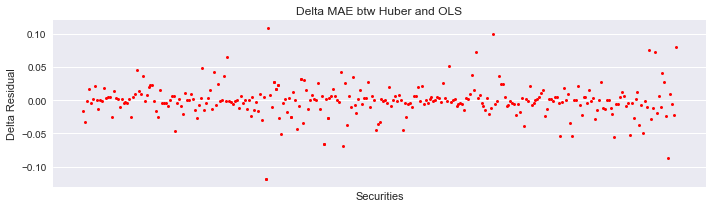

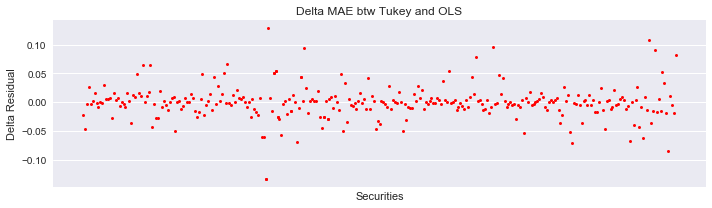

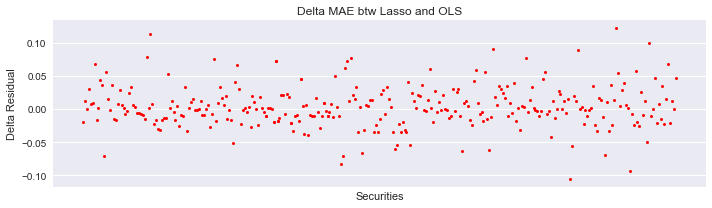

In [148]:
plt.subplots(figsize=(10,3))
plt.plot(huber_std_residuals.abs().mean()-ols_std_residuals.abs().mean(),'ro',markersize=3)
plt.xlabel("Securities")
plt.ylabel("Delta Residual")
plt.title("Delta MAE btw Huber and OLS")
plt.xticks([], [])
plt.tight_layout()
plt.show()

plt.subplots(figsize=(10,3))
plt.plot(tukey_std_residuals.abs().mean()-ols_std_residuals.abs().mean(),'ro',markersize=3)
plt.xlabel("Securities")
plt.ylabel("Delta Residual")
plt.title("Delta MAE btw Tukey and OLS")
plt.xticks([], [])
plt.tight_layout()
plt.show()

plt.subplots(figsize=(10,3))
plt.plot(lasso_std_residuals.abs().mean()-ols_std_residuals.abs().mean(),'ro',markersize=3)
plt.xlabel("Securities")
plt.ylabel("Delta Residual")
plt.title("Delta MAE btw Lasso and OLS")
plt.xticks([], [])
plt.tight_layout()
plt.show()

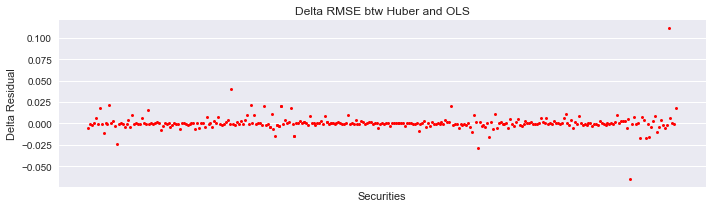

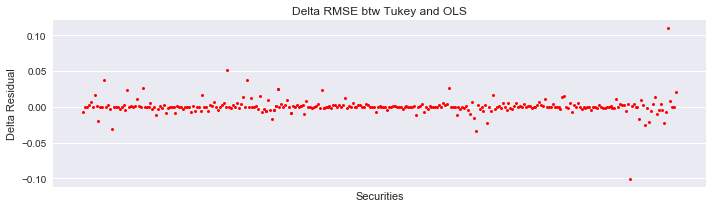

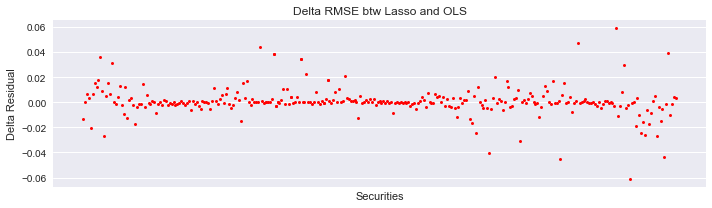

In [149]:
plt.subplots(figsize=(10,3))
plt.plot(rmse(huber_std_residuals)-rmse(ols_std_residuals),'ro',markersize=3)
plt.xlabel("Securities")
plt.ylabel("Delta Residual")
plt.title("Delta RMSE btw Huber and OLS")
plt.xticks([], [])
plt.tight_layout()
plt.show()

plt.subplots(figsize=(10,3))
plt.plot(rmse(tukey_std_residuals)-rmse(ols_std_residuals),'ro',markersize=3)
plt.xlabel("Securities")
plt.ylabel("Delta Residual")
plt.title("Delta RMSE btw Tukey and OLS")
plt.xticks([], [])
plt.tight_layout()
plt.show()

plt.subplots(figsize=(10,3))
plt.plot(rmse(lasso_std_residuals)-rmse(ols_std_residuals),'ro',markersize=3)
plt.xlabel("Securities")
plt.ylabel("Delta Residual")
plt.title("Delta RMSE btw Lasso and OLS")
plt.xticks([], [])
plt.tight_layout()
plt.show()

### Function graphs for plotting the Residual and R^2 Distribution

In [150]:
def graphs(ols_r2,huber_r2,tukey_r2,lasso_r2,ols_std_residuals,huber_std_residuals,tukey_std_residuals,lasso_std_residuals,string):
    ols_r2,huber_r2,tukey_r2,ols_std_residuals,huber_std_residuals,tukey_std_residuals=ols_r2.copy(),huber_r2.copy(),tukey_r2.copy(),ols_std_residuals.copy(),huber_std_residuals.copy(),tukey_std_residuals.copy()
    plt.subplots(figsize=(16,4))
    plt.suptitle("R2 distribution for : "+string, size =15)
    plt.subplot(141)
    plt.hist(ols_r2,bins="auto")
    plt.title("OLS R2 distribution")
    plt.subplot(142)
    plt.hist(huber_r2,bins="auto")
    plt.title("Huber R2 distribution")
    plt.subplot(143)
    plt.hist(tukey_r2,bins="auto")
    plt.title("Tukey R2 distribution")
    plt.subplot(144)
    plt.hist(lasso_r2,bins="auto")
    plt.title("Lasso R2 distribution")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    plt.subplots(figsize=(16,4))
    plt.suptitle("MAE distribution for : "+string, size =15)
    plt.subplot(141)
    plt.hist(ols_std_residuals.abs().mean(),bins="auto")
    plt.title("OLS MAE distribution")
    plt.subplot(142)
    plt.hist(huber_std_residuals.abs().mean(),bins="auto")
    plt.title("Huber MAE distribution")
    plt.subplot(143)
    plt.hist(tukey_std_residuals.abs().mean(),bins="auto")
    plt.title("Tukey MAE distribution")
    plt.subplot(144)
    plt.hist(lasso_std_residuals.abs().mean(),bins="auto")
    plt.title("Lasso MAE distribution")
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    plt.subplots(figsize=(16,4))
    plt.suptitle("RMSE distribution for : "+string,size =15)
    plt.subplot(141)
    plt.hist(rmse(ols_std_residuals),bins="auto")
    plt.title("OLS RMSE distribution")
    plt.subplot(142)
    plt.hist(rmse(huber_std_residuals),bins="auto")
    plt.title("Huber RMSE distribution")
    plt.subplot(143)
    plt.hist(rmse(tukey_std_residuals),bins="auto")
    plt.title("Tukey RMSE distribution")
    plt.subplot(144)
    plt.hist(rmse(lasso_std_residuals),bins="auto")
    plt.title("Lasso RMSE distribution")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    plt.subplots(figsize=(10,3))
    plt.title("MAE Comparision : "+ string,size =15)
    p1=sns.kdeplot(lasso_std_residuals.abs().mean(), shade=True, color="c",label="Lasso")
    p1=sns.kdeplot(ols_std_residuals.abs().mean(), shade=True, color="r",label="OLS")
    p1=sns.kdeplot(huber_std_residuals.abs().mean(), shade=True, color="b",label="Huber")
    p1=sns.kdeplot(tukey_std_residuals.abs().mean(), shade=True, color="g",label="Tukey")
    
    plt.show()
    
    plt.subplots(figsize=(10,3))
    plt.title("RMSE Comparision : "+ string,size =15)
    p1=sns.kdeplot(rmse(lasso_std_residuals), shade=True, color="c",label="Lasso")
    p1=sns.kdeplot(rmse(ols_std_residuals), shade=True, color="r",label="OLS")
    p1=sns.kdeplot(rmse(huber_std_residuals), shade=True, color="b",label="Huber")
    p1=sns.kdeplot(rmse(tukey_std_residuals), shade=True, color="g",label="Tukey")
    
    plt.show()

### Regression with No Intercept for All Securities 
   

<s>### Key Highlights:

1. R2 : OLS has some extremely poor R^2 (< -1), which shows it performs bad compared to the other two method who both have R^2 between (-1,1)   

2. MAE : All the three MAEs seem to peak around 0.8, with Huber and Tukey having higher frequencies at 0.8 than OLS. We can clearly see Huber to have a more condensed distribution than both OLS and Tukey i.e. Better performing. Although still difficult to clearly see.
    
3. RMSE : All three have RMSE peaking at ~ 0.9 with Huber and Tukey both have more frequent lower values of RMSE i.e. better than OLS. Although still difficult to clearly see.
    
4. Overlaided distribution : Difficult to clearly say anything, all three look similar

1. $R^2$ for Lasso is much more compact in the (-1,1) range
2. MAE has less extreme range and higher peak count at 0.8
3. RMSE is better than OLS based on extreem values and distribution.
4. Similar profile for Overlaid plots, difficult to comment anything 

================ Results for All Securities without Intercept ================



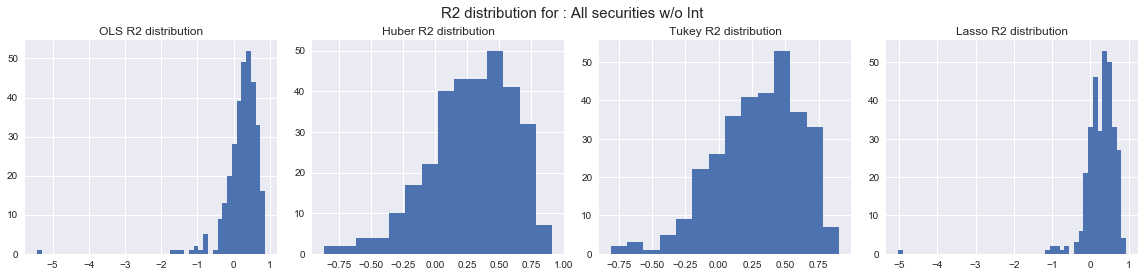

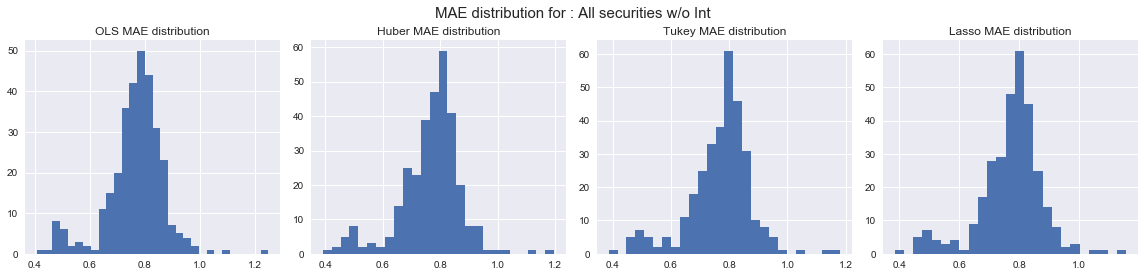

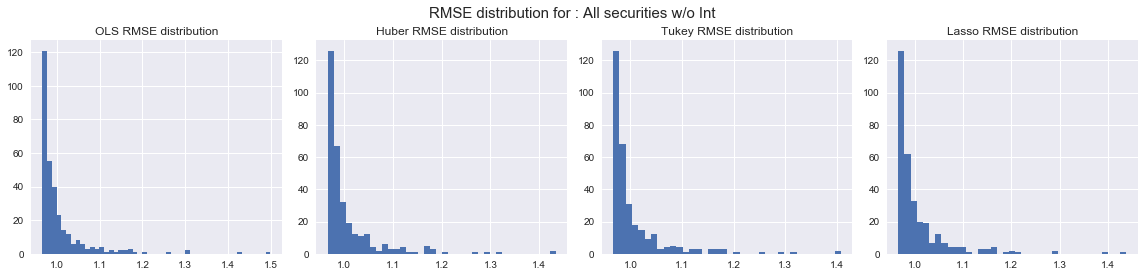

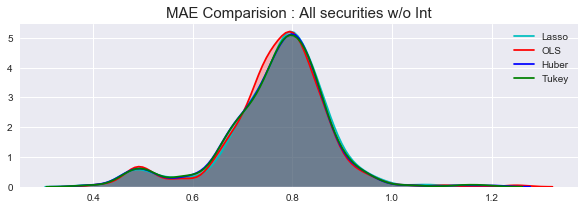

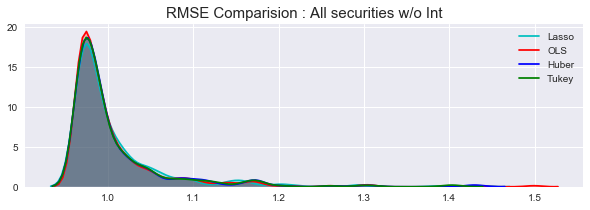

In [151]:
print("================ Results for All Securities without Intercept ================\n")
graphs(ols_r2,huber_r2,tukey_r2,lasso_r2,ols_std_residuals,huber_std_residuals,tukey_std_residuals,lasso_std_residuals,"All securities w/o Int")

###  Regression with Intercept for All Securities 
   

<s>###  Key Highlights:
    
    1. R2 : Here we see all three have some case where R2 are less than <1, but still OLS has more worse off R2 than the other two i.e. more extreme left values and values <-1 more often
    
    2. MAE : All the three MAEs seem to peak around 0.8, with Huber and Tukey having lower frequencies at 0.8 than OLS. We can  see Huber and Tukey both to have a more condensed distribution than OLS i.e. Better performing. But still difficult to clearly make out which is better
    
    3. RMSE : All three have RMSE peaking at ~ 0.9 with Huber and Tukey both have more frequent lower values of RMSE i.e. better than OLS. Although still difficult to clearly see.
    
    4. Overlaided distribution : Only this visible in  RMSE overlaid plot is the frequency at ~0.97 peak for OLS is lesser than the other two, i.e. Tukey and Huber are better than OLS

1. $R^2$ for Lasso is much more compact in the (-1,1) range
2. MAE has less extreme range and higher peak count at 0.8 compared to OLS
3. RMSE is better than OLS based on distribution.
4. Similar profile for Overlaid plots, difficult to comment anything 

================ Results for All Securities with Intercept ================



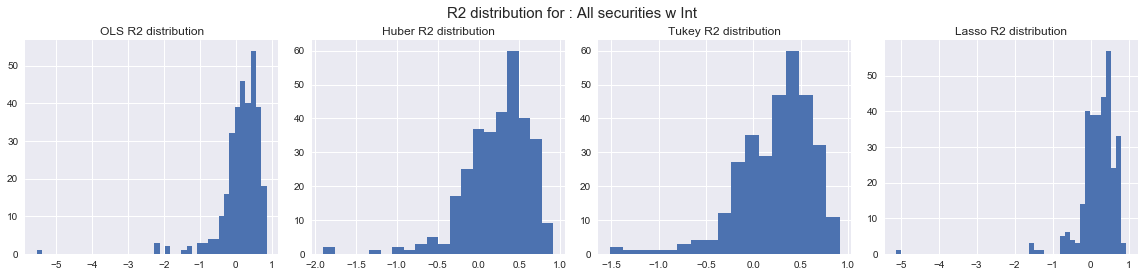

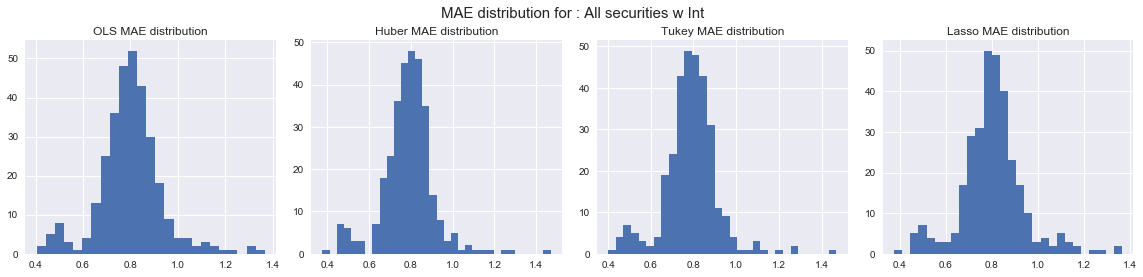

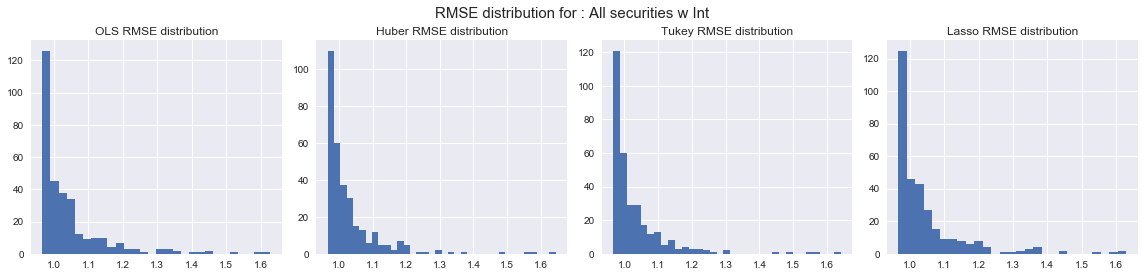

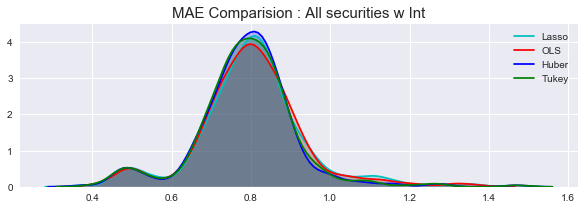

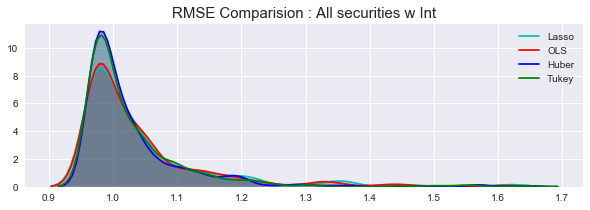

In [152]:
print("================ Results for All Securities with Intercept ================\n")
graphs(ols_wInt_r2,huber_wInt_r2,tukey_wInt_r2,lasso_wInt_r2,ols_wInt_std_residuals,huber_wInt_std_residuals,tukey_wInt_std_residuals,lasso_wInt_std_residuals,"All securities w Int")

### Fat tail Securities
    -One of the reason we don't see a clear winnner is than we have taken a whole universe of securities.
    -Huber and Tukey perform better than OLS when there are in-sample Outliers which OLS tries to fit and  are ignored by Huber and Tukey. Thus when we run out of sample test, Tukey and Huber should perform better than OLS
    - So let's focus on heavy or fat tail securities that is more voltatile securities

### Selecting a List of Securities with in-sample (30 days) Kurtosis > 10
    I end up with ~20 names

In [153]:
heavy_kurt_sec_list= sec_ret.loc[:,(sec_ret.iloc[:30,:].kurt()>10)].columns.values
heavy_kurt_sec=sec_ret.loc[:,heavy_kurt_sec_list]
print(heavy_kurt_sec.shape)
heavy_kurt_sec.iloc[:30,:].kurt()

(45, 20)


AIG      10.663452
ANTM     10.584993
AON      10.743045
BMY      14.793662
CELG     22.044591
CHTR     16.305231
CNC      28.408391
GLIBA    17.862813
GS       11.997968
IMMU     15.985271
LBRDK    15.860346
MDR      15.617876
MDT      10.532749
MUSA     14.058667
QEP      23.750074
SAGE     19.667476
STI      10.195043
SYF      13.716346
SYK      15.403565
XLNX     14.736724
dtype: float64

### Plotting return distribution for the 20 heavy tail names
    Just to visualize the return distributions

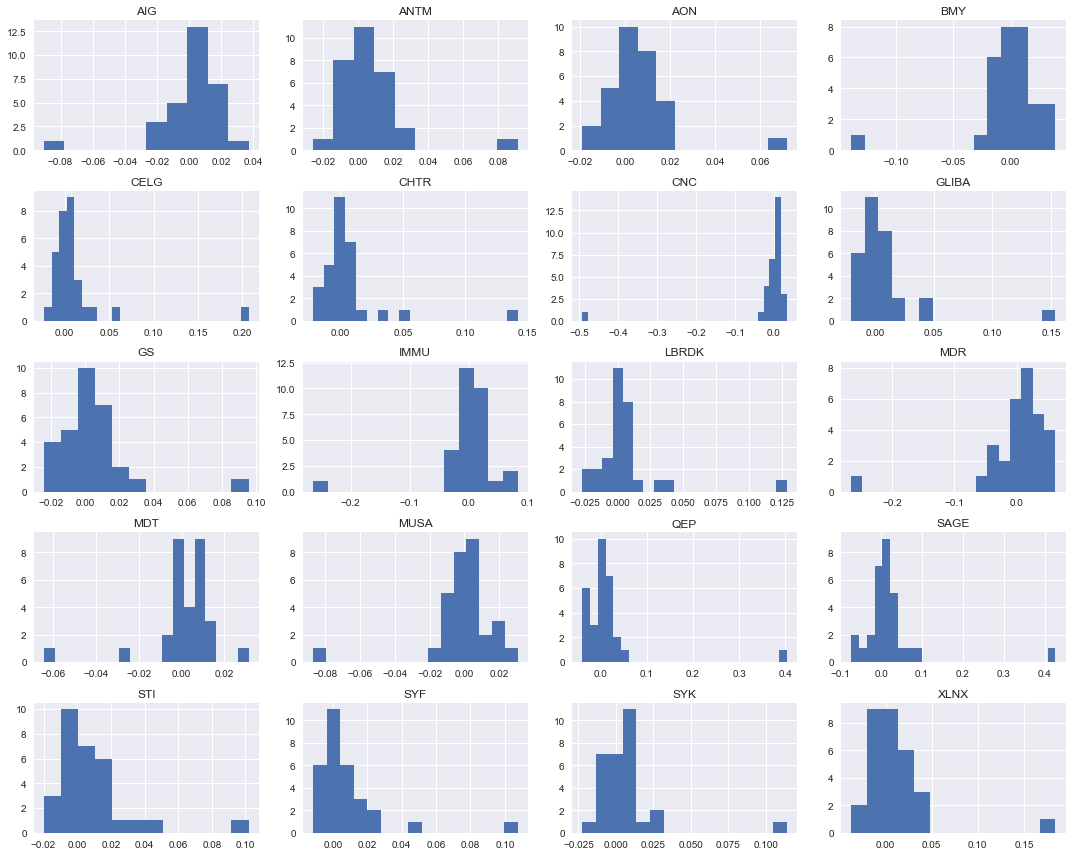

In [49]:
plt.subplots(figsize = (15, 12))
for i in range(0,heavy_kurt_sec.shape[1]):
    plt.subplot(5, 4, i+1)
    plt.title(heavy_kurt_sec.columns[i])
    plt.hist(heavy_kurt_sec.iloc[:30,i],bins="auto")

plt.tight_layout()
plt.show()

###  Regression without Intercept for Fat tail Securities 
   

<s>###  Key Highlights:
    
    1. R2 : As expected OLS performs poorly compared to both Huber and Tukey, who both have resonable R2 out of sample.
    
    2. MAE : MAE values for OLS is much more concentrated on the right, and relatively more spread out of Huber and Tukey i.e. better performance by the two.
    
    3. RMSE : Although Huber and Tukey have more extreme values avaiable, their plots still look more condensed to the left than OLS.
    
    4. Overlaided distribution : For the MAE overlay, we see clearly than Huber and Tukey are less spread to the right, and have a higher frequency at the peak of 0.85-0.87. 
    For RMSE overlay, we get contradictory results. OLS looks to be more concentrated in the left and have a higher peak frequency at the max frequency point ~0.975
    
    
    In the next case we see the results (w Intercept) be much more clear and decisive 

================ Results for Heavy Tail Securities without Intercept ================



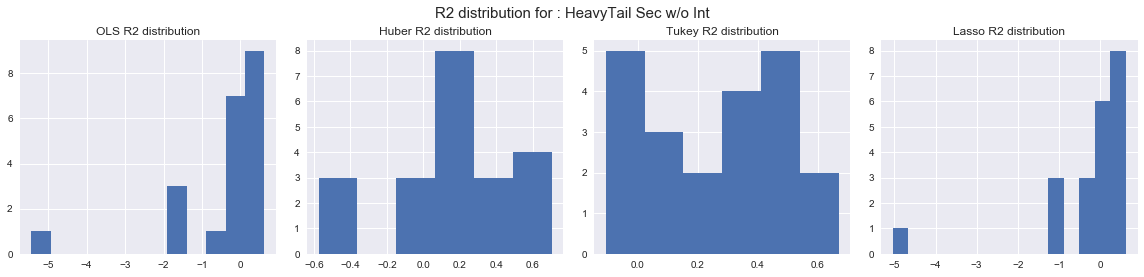

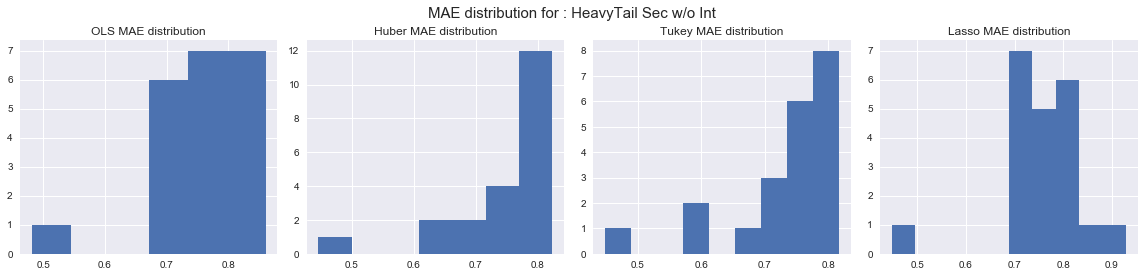

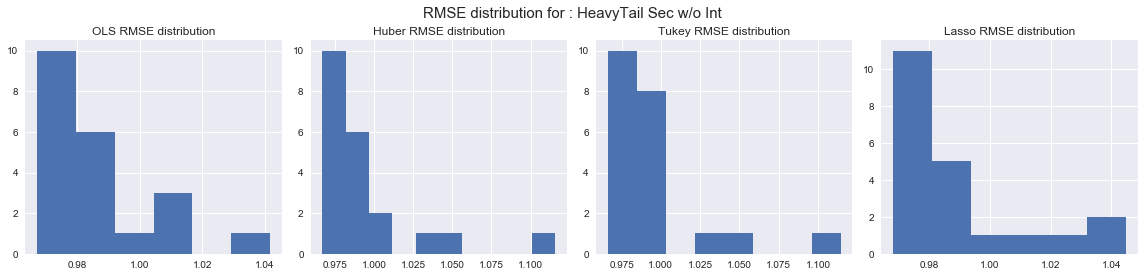

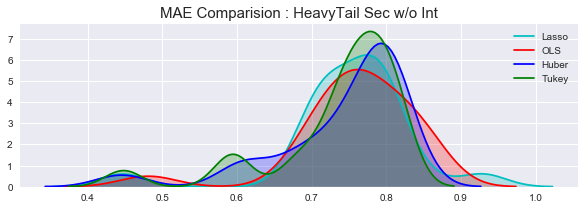

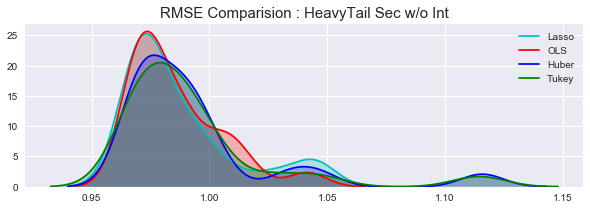

In [154]:
print("================ Results for Heavy Tail Securities without Intercept ================\n")
graphs(ols_r2.loc[:,heavy_kurt_sec_list],huber_r2.loc[:,heavy_kurt_sec_list],tukey_r2.loc[:,heavy_kurt_sec_list],\
       lasso_r2.loc[:,heavy_kurt_sec_list],ols_std_residuals.loc[:,heavy_kurt_sec_list],\
       huber_std_residuals.loc[:,heavy_kurt_sec_list],tukey_std_residuals.loc[:,heavy_kurt_sec_list],\
       lasso_std_residuals.loc[:,heavy_kurt_sec_list],"HeavyTail Sec w/o Int")

###  Regression with Intercept for Fat tail Securities 
   

<s>###  Key Highlights:
    
    1. R2 : As expected OLS performs poorly compared to both Huber and Tukey, who both have resonable R2 out of sample. As above. 
    
    2. MAE : MAE for OLS has more extreme values on the right and is more concentrated around 0.8-1 compared to Huber which are more concentrated around 0.7-0.9 and Tukey which is concentrated around 0.7-0.8. Tukey is better performing than the other two
    
    3. RMSE : OLS is performing worse as more extreme right value and overall the distribution is much more concentrated on the right than left (i.e overall higher errors). Here again we see Tukey to perform the best as most of errors are around 0.7-0.8 range
    
    4. Overlaided distribution : From both the overlay we see OLS perform worse than both Tukey and Huber. OLS error distribution is more spread out, and has a higher density on the right sides.

    

<s>### Why Intercept matters?
    When we allow regression to have an intercept, we give another parameter that can be varied. And in case of OLS, it overfits the in-sample outlier residuals even more. Hence we see the most difference in OLS and Huber/Tukey when we take the intercept

1. $R^2$ has more values to the right of 0, hence better
2. OLS MAE looks better
3. Lasso RMSE is better than OLS and more centered towards the right
4. From overlay plots we see MAE wise Lasso does a better job than OLS, for RMSE very similar plots

================ Results for Skewed Security with Intercept ================



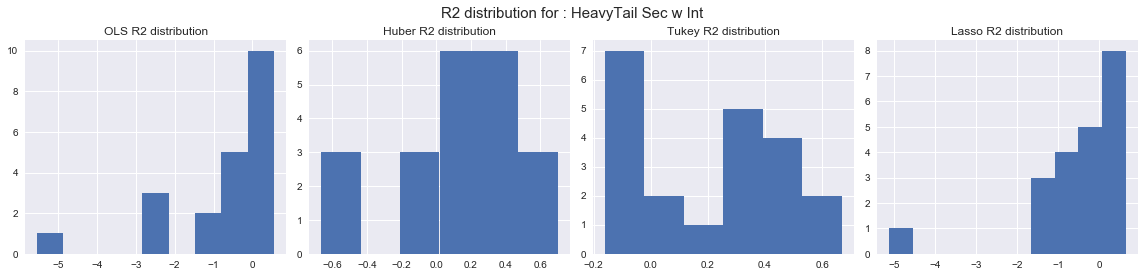

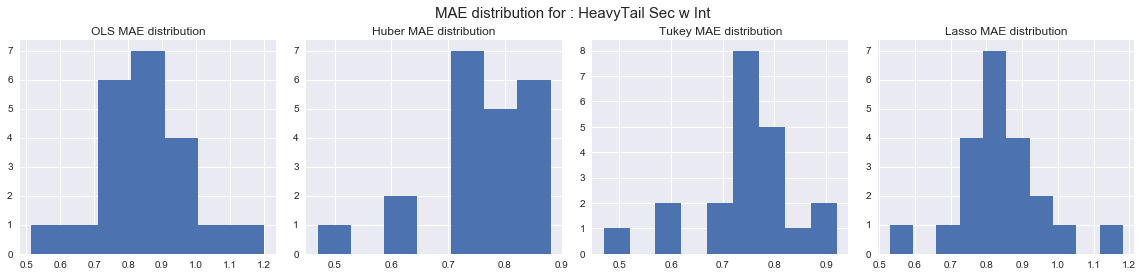

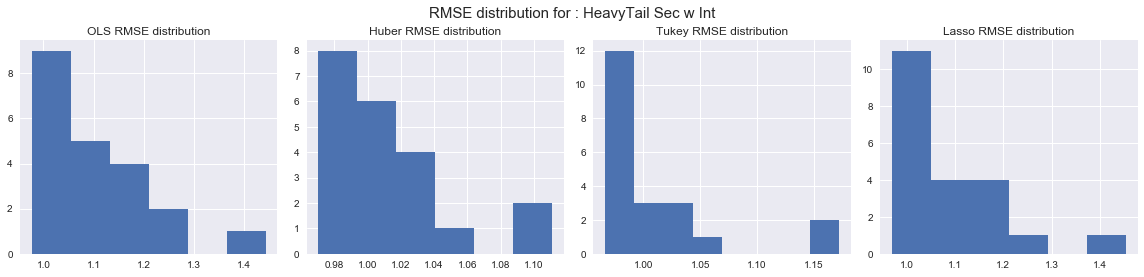

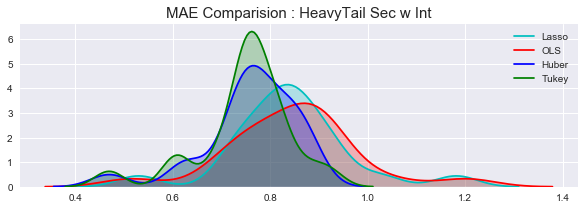

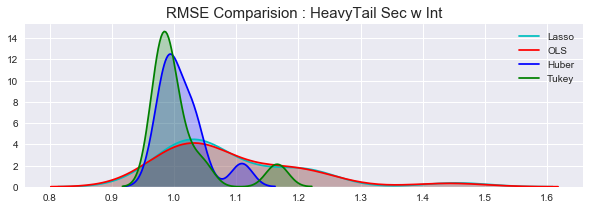

In [155]:
print("================ Results for Skewed Security with Intercept ================\n")
graphs(ols_wInt_r2.loc[:,heavy_kurt_sec_list],huber_wInt_r2.loc[:,heavy_kurt_sec_list]\
       ,tukey_wInt_r2.loc[:,heavy_kurt_sec_list],lasso_wInt_r2.loc[:,heavy_kurt_sec_list],\
       ols_wInt_std_residuals.loc[:,heavy_kurt_sec_list],huber_wInt_std_residuals.loc[:,heavy_kurt_sec_list],\
       tukey_wInt_std_residuals.loc[:,heavy_kurt_sec_list],lasso_wInt_std_residuals.loc[:,heavy_kurt_sec_list],\
      "HeavyTail Sec w Int")

# 4. Parameter Optimization
    - As Huber and Tukey both have a parameter that can be varied, we want to see how does that impact the optimization
    - While plotting we show the OLS value of the parameter using a dashed black line

### Perfomance metrics for OLS
    Time taken to run OLS w/o Intercept : 3.096200704574585
    M-MAE of r:  0.010980387062870026
    M-MAE of r_z:  0.7675349379832814
    M-RMSE of r: 0.015053321440878497
    M-RMSE of r_z: 1.0057791815803117
    M-R2 is : R2    0.402897
   
    Time taken to run OLS w Intercept : 5.1063392162323
    M-MAE of r: 0.01140080797362374
    M-MAE of r_z: 0.8004578715059935
    M-RMSE of r: 0.015519959011536221
    M-RMSE of r_z: 1.0425380027436888
    M-R2 is : R2    0.414937
    

In [156]:
ols_metric=[0.015053321440878497,1.0057791815803117,0.010980387062870026,0.7675349379832814,0.402897,3.096200704574585]
ols_metric_wInt=[0.015519959011536221,1.0425380027436888,0.01140080797362374,0.8004578715059935,0.414937,5.1063392162323]

###  Huber without Intercept

In [65]:
idx = ["M-RMSE r","M-RMSE r_z","M-MAE r","M-MAE r_z","R2","RunTime"]

para_huber = np.arange(0.5,6.1,0.25)
res_huber  = pd.DataFrame(columns=para_huber,index=idx)
for i in range(len(para_huber)):
    time_start = tm.time()
    r,r_z,r2 = run_huber(sec_ret,index_ret,mat,t=para_huber[i])
    time_exe = tm.time() - time_start
    err_r = rmse(r).mean()
    err_a = rmse(r_z).mean()
    abs_r = r.abs().mean().mean()
    abs_a = r_z.abs().mean().mean()
    r2=abs(r2).mean().mean()
    res_huber[para_huber[i]] = [err_r,err_a,abs_r,abs_a,r2,time_exe]

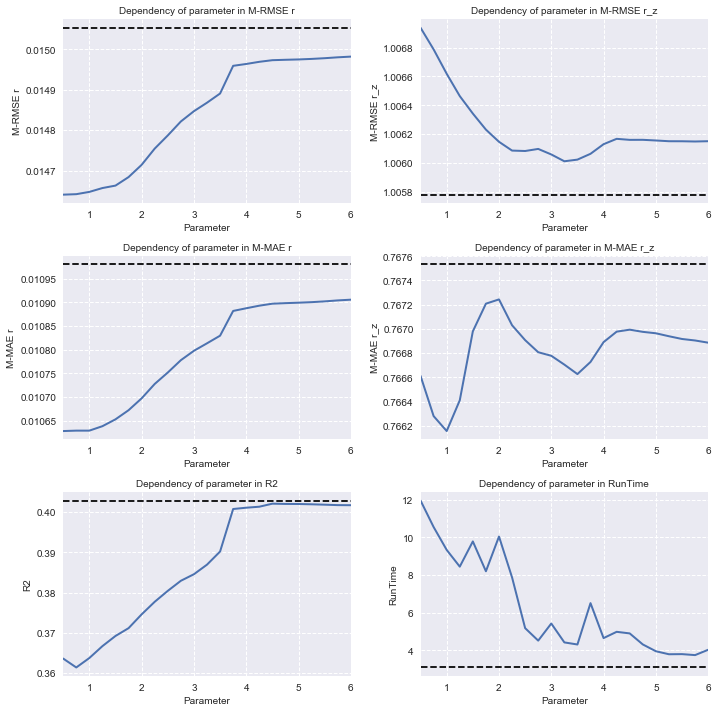

In [87]:
i=1
plt.subplots(figsize=(10,10))
for key in idx:
    plt.subplot(3,2,i)
    res_huber.loc[key].plot(linewidth=2.0)
    plt.title("Dependency of parameter in "+key,fontsize=10)
    plt.xlabel("Parameter",fontsize=10)
    #dashed line for OLS metrics
    plt.hlines(ols_metric[i-1],0.5,6,linestyles='--') 
    plt.ylabel(key,fontsize=10)
    plt.grid(linestyle="--")
    i=i+1
plt.tight_layout()
plt.show()


### Huber with Intercept

In [67]:
idx = ["M-RMSE r","M-RMSE r_z","M-MAE r","M-MAE r_z","R2","RunTime"]

para_huber = np.arange(0.5,6.1,0.25)
res_huber_int  = pd.DataFrame(columns=para_huber,index=idx)
for i in range(len(para_huber)):
    time_start = tm.time()
    r,r_z,r2 = run_huber(sec_ret,index_ret,mat,t=para_huber[i],intercept=True)
    time_exe = tm.time() - time_start
    err_r = rmse(r).mean()
    err_a = rmse(r_z).mean()
    abs_r = r.abs().mean().mean()
    abs_a = r_z.abs().mean().mean()
    r2=r2.abs().mean().mean()
    res_huber_int[para_huber[i]] = [err_r,err_a,abs_r,abs_a,r2,time_exe]

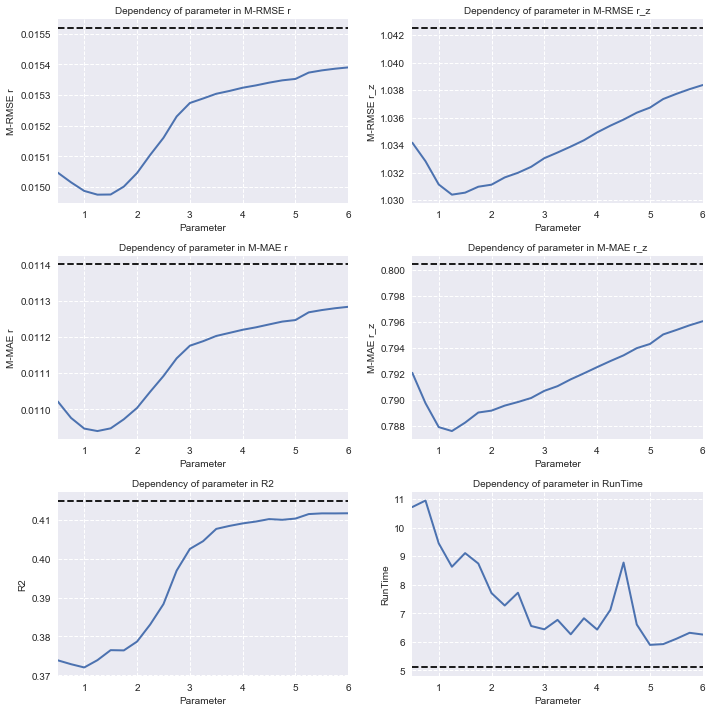

In [86]:
i=1
plt.subplots(figsize=(10,10))
for key in idx:
    plt.subplot(3,2,i)
    res_huber_int.loc[key].plot(linewidth=2.0)
    plt.title("Dependency of parameter in "+key,fontsize=10)
    plt.xlabel("Parameter",fontsize=10)
    plt.ylabel(key,fontsize=10)
    #dashed line for OLS metrics
    plt.hlines(ols_metric_wInt[i-1],0.5,6,linestyles='--')
    plt.grid(linestyle="--")
    i=i+1
plt.tight_layout()
plt.show()


<s>###  Finding 
    1. As Parameter keeps increasing the Huber function starts to behave like the OLS regression in all metrics
    2. The Optimal Parameter value looks to be in the range 1.0-1.5, and the default value 1.345 falls in this range.
    3. One of contrasting things we expect to see between Tukey and Huber is on Runtime, We expect runtime to start to decrease as we increase the parameter value in Huber, but that's not the case in Tukey. Because for Huber we have only one minima contrasted with huber where we may have multiple minima.

### Tukey without Intercept 

In [69]:
idx = ["M-RMSE r","M-RMSE r_z","M-MAE r","M-MAE r_z","R2","RunTime"]

para = np.arange(0.25,7.1,0.25)
res_tukey  = pd.DataFrame(columns=para,index=idx)
for i in range(len(para)):
    time_start = tm.time()
    r,r_z,r2 = run_tukey(sec_ret,index_ret,mat,c=para[i])
    time_exe = tm.time() - time_start
    err_r = rmse(r).mean() 
    err_a = rmse(r_z).mean() 
    abs_r = r.abs().mean().mean()
    abs_a = r_z.abs().mean().mean()
    r2 = r2.abs().mean().mean()
    res_tukey[para[i]] = [err_r,err_a,abs_r,abs_a,r2,time_exe]

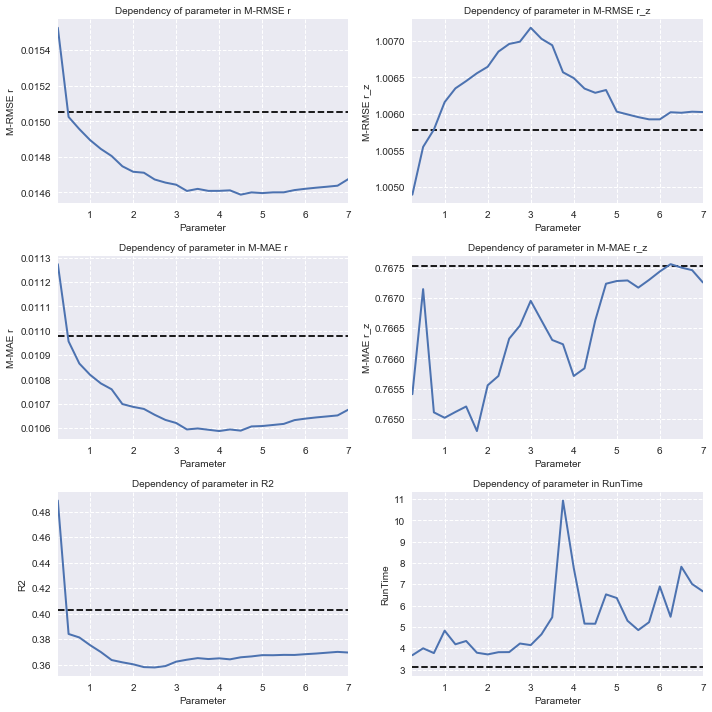

In [85]:
i=1
plt.subplots(figsize=(10,10))
for key in idx:
    plt.subplot(3,2,i)
    res_tukey.loc[key].plot(linewidth=2.0)
    plt.title("Dependency of parameter in "+key,fontsize=10)
    plt.xlabel("Parameter",fontsize=10)
    plt.ylabel(key,fontsize=10)
    #dashed line for OLS metrics
    plt.hlines(ols_metric[i-1],0.25,7,linestyles='--')
    plt.grid(linestyle="--")
    i=i+1
plt.tight_layout()
plt.show()

### Tukey with Intercept

In [71]:
idx = ["M-RMSE r","M-RMSE r_z","M-MAE r","M-MAE r_z","R2","RunTime"]

para = np.arange(0.25,7.1,0.25)
res_tukey_int  = pd.DataFrame(columns=para,index=idx)
for i in range(len(para)):
    time_start = tm.time()
    r,r_z,r2 = run_tukey(sec_ret,index_ret,mat,c=para[i],intercept=True)
    time_exe = tm.time() - time_start
    err_r = rmse(r).mean() 
    err_a = rmse(r_z).mean() 
    abs_r = r.abs().mean().mean()
    abs_a = r_z.abs().mean().mean()
    r2 = r2.abs().mean().mean()
    res_tukey_int[para[i]] = [err_r,err_a,abs_r,abs_a,r2,time_exe]

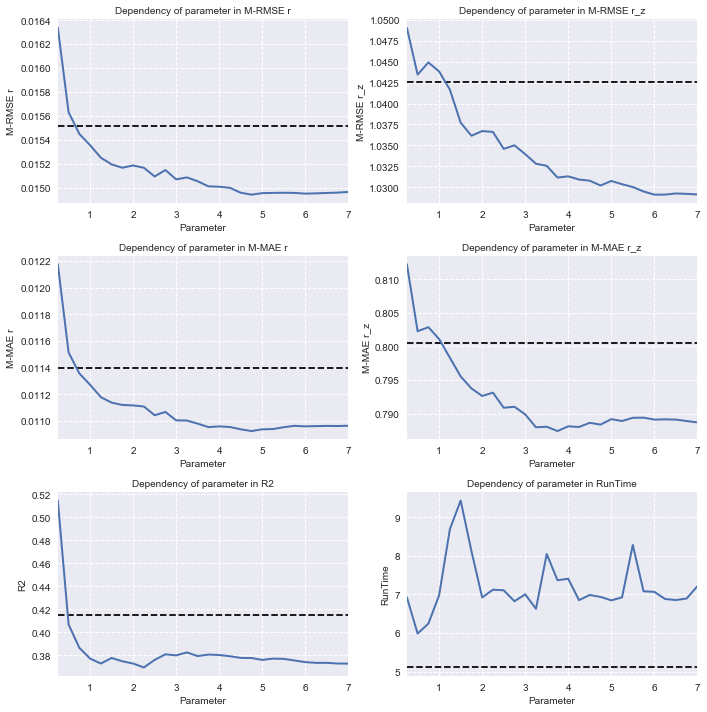

In [84]:
i=1
plt.subplots(figsize=(10,10))
for key in idx:
    plt.subplot(3,2,i)
    res_tukey_int.loc[key].plot(linewidth=2.0)
    plt.title("Dependency of parameter in "+key,fontsize=10)
    plt.xlabel("Parameter",fontsize=10)
    plt.ylabel(key,fontsize=10)
    #dashed line for OLS metrics
    plt.hlines(ols_metric_wInt[i-1],0.25,7,linestyles='--')
    plt.grid(linestyle="--")
    i=i+1
plt.tight_layout()
plt.show()

<s>###  Findings
    1. The most important finding here is the RunTime doesn't decrease rather increases as we increase the parameter,  this is due to the algo finding multiple minimas 
    2. The Optimal Parameter value looks to be in the range 3.0-5.0, and the default value 4.685 falls in this range.
    3. As the optimization function is based on the derivative rather than the loss function directly, we do not see the Huber results converging to OLS.

### Lasso without Intercept 

In [172]:
idx = ["M-RMSE r","M-RMSE r_z","M-MAE r","M-MAE r_z","R2","RunTime"]
para=np.logspace(-8,-1, num=25,base=10)
res_lasso  = pd.DataFrame(columns=para,index=idx)
for i in range(len(para)):
    time_start = tm.time()
    r,r_z,r2 = run_lasso(sec_ret,index_ret,mat,alpha=para[i])
    time_exe = tm.time() - time_start
    err_r = rmse(r).mean() 
    err_a = rmse(r_z).mean() 
    abs_r = r.abs().mean().mean()
    abs_a = r_z.abs().mean().mean()
    r2 = r2.abs().mean().mean()
    res_lasso[para[i]] = [err_r,err_a,abs_r,abs_a,r2,time_exe]

In [173]:
res_lasso.T

,M-RMSE r,M-RMSE r_z,M-MAE r,M-MAE r_z,R2,RunTime
1.000000e-08,0.015053,1.005783,0.010980,0.767538,0.402902,3.880764
1.957342e-08,0.015052,1.005787,0.010979,0.767540,0.402902,3.694115
3.831187e-08,0.015050,1.005794,0.010978,0.767547,0.402889,3.739709
7.498942e-08,0.015047,1.005809,0.010976,0.767564,0.402858,3.722667
1.467799e-07,0.015042,1.005837,0.010971,0.767597,0.402801,3.652725
2.872985e-07,0.015031,1.005889,0.010962,0.767616,0.402766,3.630584
5.623413e-07,0.015012,1.005975,0.010947,0.767698,0.402629,4.158960
1.100694e-06,0.014978,1.006094,0.010919,0.767702,0.401913,4.302083
2.154435e-06,0.014924,1.006313,0.010880,0.768463,0.399955,3.992862
4.216965e-06,0.014860,1.006616,0.010836,0.770398,0.393958,4.860457


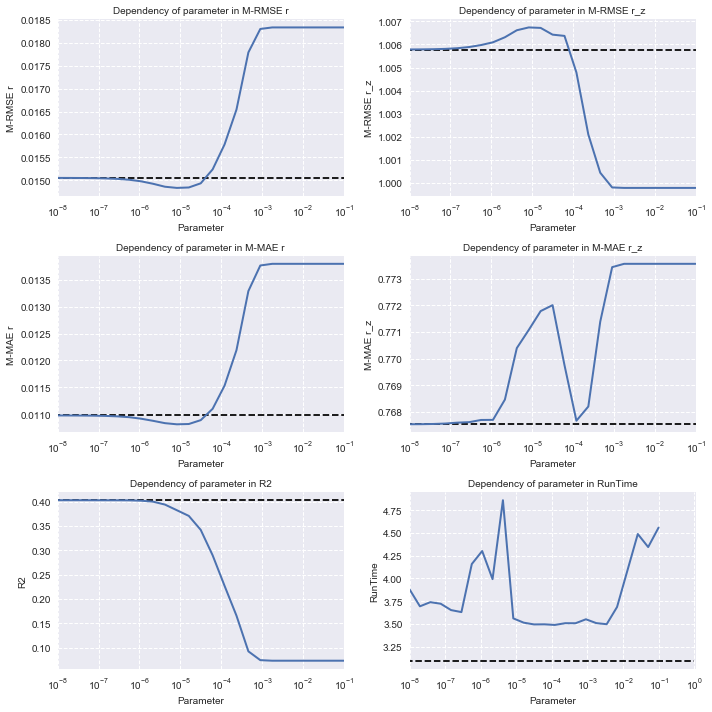

In [174]:
i=1
plt.subplots(figsize=(10,10))
for key in idx:
    
    plt.subplot(3,2,i)
    res_lasso.loc[key].plot(linewidth=2.0)
    plt.title("Dependency of parameter in "+key,fontsize=10)
    plt.xlabel("Parameter",fontsize=10)
    plt.ylabel(key,fontsize=10)
    plt.xscale('log')
    #dashed line for lasso metrics
    plt.hlines(ols_metric[i-1],0.0,1,linestyles='--')
    plt.grid(linestyle="--")
    i=i+1
plt.xlim(-0.01,1.1)
plt.tight_layout()
plt.show()

### Lasso with Intercept

In [175]:
idx = ["M-RMSE r","M-RMSE r_z","M-MAE r","M-MAE r_z","R2","RunTime"]
res_lasso_int  = pd.DataFrame(columns=para,index=idx)
for i in range(len(para)):
    time_start = tm.time()
    r,r_z,r2 = run_lasso(sec_ret,index_ret,mat,alpha=para[i],intercept=True)
    time_exe = tm.time() - time_start
    err_r = rmse(r).mean() 
    err_a = rmse(r_z).mean() 
    abs_r = r.abs().mean().mean()
    abs_a = r_z.abs().mean().mean()
    r2 = r2.abs().mean().mean()
    res_lasso_int[para[i]] = [err_r,err_a,abs_r,abs_a,r2,time_exe]

In [176]:
res_lasso_int.T

,M-RMSE r,M-RMSE r_z,M-MAE r,M-MAE r_z,R2,RunTime
1.000000e-08,0.015519,1.042550,0.011400,0.800472,0.414880,3.776266
1.957342e-08,0.015518,1.042561,0.011399,0.800486,0.414823,4.069025
3.831187e-08,0.015516,1.042583,0.011398,0.800513,0.414705,3.888412
7.498942e-08,0.015513,1.042624,0.011395,0.800562,0.414461,4.304372
1.467799e-07,0.015506,1.042704,0.011389,0.800651,0.414021,3.940259
2.872985e-07,0.015493,1.042857,0.011379,0.800835,0.413232,4.207272
5.623413e-07,0.015470,1.043132,0.011360,0.801023,0.411643,4.264600
1.100694e-06,0.015430,1.043505,0.011325,0.801038,0.408507,3.924255
2.154435e-06,0.015375,1.044191,0.011276,0.801275,0.403502,3.780288
4.216965e-06,0.015308,1.045128,0.011224,0.802865,0.395800,3.544267


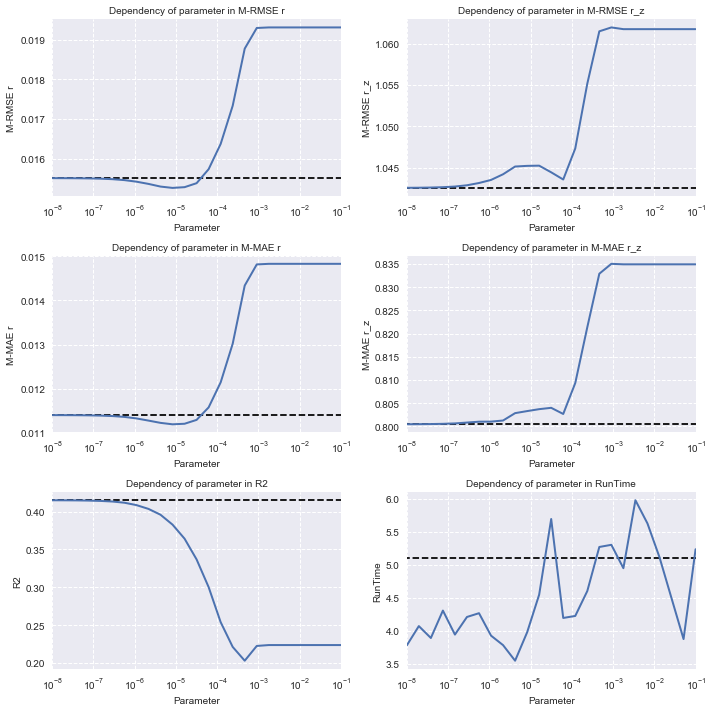

In [177]:
i=1
plt.subplots(figsize=(10,10))
for key in idx:
    plt.subplot(3,2,i)
    res_lasso_int.loc[key].plot(linewidth=2.0)
    plt.title("Dependency of parameter in "+key,fontsize=10)
    plt.xlabel("Parameter",fontsize=10)
    plt.ylabel(key,fontsize=10)
    plt.xscale('log')
    #dashed line for OLS metrics
    plt.hlines(ols_metric_wInt[i-1],0.0,1,linestyles='--')
    plt.grid(linestyle="--")
    i=i+1
plt.tight_layout()
plt.show()

###  Findings
    1. We see we get the best $R^2$ when alpha is close to zero, so that OLS and Lasso are similar
    2. We do see a overall drop in the RMSE/MAE close to alpha = $10^-5$, but we see std. error jump up. This means while in certain securities the error goes does, but for the others errors increase. In magnitude, the increase in error is outweighted by decrease in error, but for std error the inc in error is higher than the dec in error
    3. No clear trend wrt time is observed

<s># 5. Results:

#### 1. We were unable to distinguish between OLS, Huber and Tukey when we considered the whole universe of securities. All three performed similarly on an aggregate level
#### 2. When we selected only the heavy tail stocks we saw robust regression method of Tukey and Huber outperforming OLS
#### 3. The most significant difference was when ran regression with Intercepts for heavy tail securities. This as explained above was as OLS ends up overfit the outlier residuals more thus ending with an even worse model.
#### 4. For Huber as we keep increasing the Parameter, we end up close to OLS. And we see the overall run-time decrease as the Parameter is increased.
#### 5. For Tukey we saw as we increase the Parameter, our optimization takes more time. 